In [1]:
import numpy as np
import os,sys
sys.path.append(os.path.abspath('./../../'))
from cell_extractor.diagnostics.ToolKit import get_DataFrame_from_query_result,find_equivalence,find_annotation_in_category,find_agreement,get_DataFrame_from_detection_df
from Controllers.MarkedCellController import MarkedCellController
from Controllers.SqlController import SqlController
from cell_extractor.CellAnnotationUtilities import CellAnnotationUtilities
from cell_extractor.CellDetectorBase import CellDetectorBase
from cell_extractor.CellDetectorTrainer import CellDetectorTrainer
from cell_extractor.utils import get_ids_in_subcategory



1.5.0


In [7]:
animal = 'DK52'
base = CellDetectorBase(animal,round=2)
features = base.get_combined_features()
controller = SqlController()
factor = controller.get_resolution(animal)
controller = MarkedCellController()
search_dict = {'FK_prep_id':animal,'FK_cell_type_id':1,'FK_annotator_id':2}
positives = get_DataFrame_from_query_result(controller.get_marked_cells(search_dict),'Sure',factor)
positives_tool = find_equivalence(positives)


calculating distance matrix
finding points that are close to each other
grouping and labeling points that are close to each other
before removing duplicates 1950
after removing duplicates 1950


In [8]:
positives.head()

,x,y,section,name
0,40797.846154,18918.984615,314.0,Sure_Beth_POSITIVE
1,40276.923077,18955.015385,314.0,Sure_Beth_POSITIVE
2,40047.076923,19538.000000,314.0,Sure_Beth_POSITIVE
3,41099.076923,20501.015385,314.0,Sure_Beth_POSITIVE
4,38792.000000,17761.015385,314.0,Sure_Beth_POSITIVE


In [ ]:
positives = get_ids_in_subcategory(features,positives)

In [ ]:
sure_positive_ids = get_ids_in_subcategory(features,round3_sure_positive)
sure_negative_ids = get_ids_in_subcategory(features,round3_sure_negative)
unsure_positive_ids = get_ids_in_subcategory(features,round3_unsure_positive)
unsure_negative_ids = get_ids_in_subcategory(features,round3_unsure_negative)
false_negative_agreed = get_ids_in_subcategory(features,false_negatives_agreed,max_distance=300)

1000
skipping, min distance 561.0641199948174
skipping, min distance 389.2118271462628


In [ ]:
print(f'sures {len(sure_positive_ids),len(sure_negative_ids)}')
print(f'unsures {len(unsure_positive_ids),len(unsure_negative_ids)}')
print(f'false neg {len(false_negative_agreed)}')

sures (196, 48)
unsures (266, 1011)
false neg 137


In [ ]:
positive_ids = sure_positive_ids+unsure_positive_ids+false_negative_agreed
negative_ids = sure_negative_ids+unsure_negative_ids
all_ids = positive_ids+negative_ids
len(positive_ids),len(negative_ids),len(all_ids)

(599, 1059, 1658)

In [ ]:
features.label = 0
features.label[positive_ids] = 1
train_features = features.iloc[all_ids]
drops = ['animal', 'section', 'index', 'row', 'col'] 
train_features=train_features.drop(drops,axis=1)
len(train_features),len(all_ids),sum(train_features.label),len(positive_ids)

/usr/local/share/pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(1658, 1658, 599, 599)

In [ ]:
models = base.load_models()

{'eta': 0.3, 'objective': 'binary:logistic', 'nthread': 7}
(829, 41) (829, 41) (829,) (1658, 41)
(829, 41) (829, 41) (829,) (1658, 41)


/usr/local/share/pipeline/lib/python3.6/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html

/usr/local/share/pipeline/lib/python3.6/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



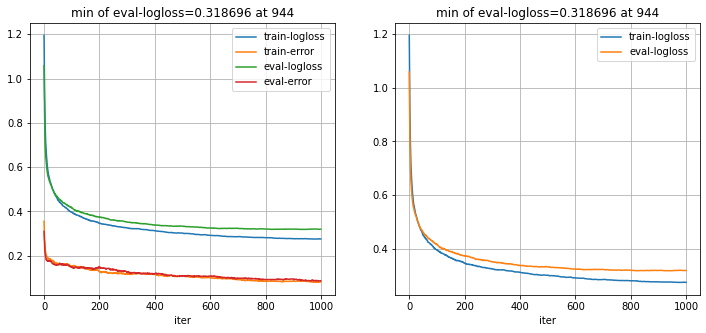

1
(829, 41) (829, 41) (829,) (1658, 41)
(829, 41) (829, 41) (829,) (1658, 41)


/usr/local/share/pipeline/lib/python3.6/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html

/usr/local/share/pipeline/lib/python3.6/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



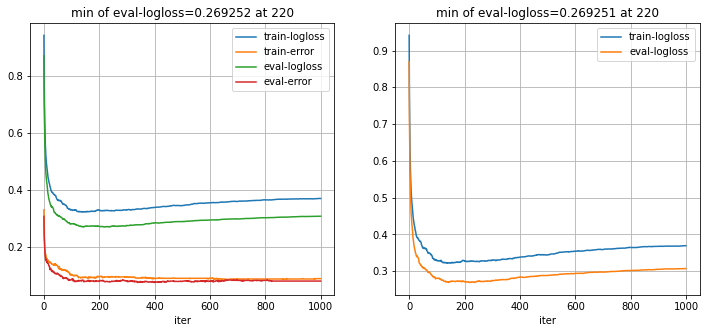

2
(829, 41) (829, 41) (829,) (1658, 41)
(829, 41) (829, 41) (829,) (1658, 41)


/usr/local/share/pipeline/lib/python3.6/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html

/usr/local/share/pipeline/lib/python3.6/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



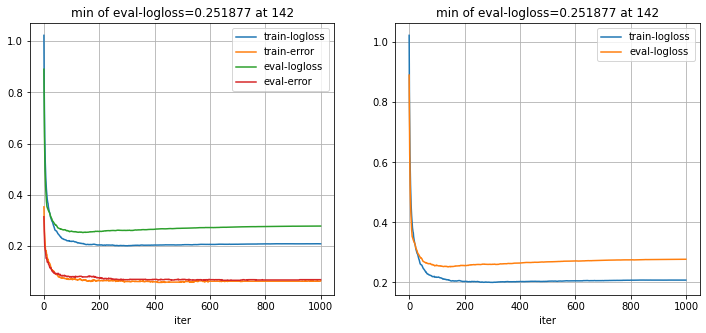

3


In [ ]:
trainer = CellDetectorTrainer('DK41',round=3)
trainer.test_xgboost(train_features,xgb_model=models[0],depths=[1,2,3])

In [ ]:
trainer = CellDetectorTrainer('DK41',round=3)
new_models = trainer.train_classifier(train_features,2,204,models = models)

{'eta': 0.3, 'objective': 'binary:logistic', 'nthread': 7}
(829, 41) (829, 41) (829,) (1658, 41)
(829, 41) (829, 41) (829,) (1658, 41)
[14:26:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


TypeError: predict() got an unexpected keyword argument 'xgb_model'